In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# **Dataset Supervisionado**

O Dataset escolhido foi um referente a informações de coletas de voz de diferentes pessoas.

Ele possui as seguintes informações representadas pelas colunas:
* meanfreq: mean frequency (in kHz)
* sd: standard deviation of frequency
* median: median frequency (in kHz)
* Q25: first quantile (in kHz)
* Q75: third quantile (in kHz)
* IQR: interquantile range (in kHz)
* skew: skewness (see note in specprop description)
* kurt: kurtosis (see note in specprop description)
* sp.ent: spectral entropy
* sfm: spectral flatness
* mode: mode frequency
* centroid: frequency centroid (see specprop)
* peakf: peak frequency (frequency with highest energy)
* meanfun: average of fundamental frequency measured across acoustic signal
* minfun: minimum fundamental frequency measured across acoustic signal
* maxfun: maximum fundamental frequency measured across acoustic signal
* meandom: average of dominant frequency measured across acoustic signal
* mindom: minimum of dominant frequency measured across acoustic signal
* maxdom: maximum of dominant frequency measured across acoustic signal
* dfrange: range of dominant frequency measured across acoustic signal
* modindx: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range
* label: male or female

Portanto, propõe-se a identificar o gênero do autor da coleta de voz a partir de todos os dados apresentados.

In [0]:
link = 'https://drive.google.com/open?id=1cPUYh9oCGZJM6NiGPN3LKE0xo7Q8rlBM'

fluff, id = link.split('=')

In [0]:
import pandas as pd


# Dataset Import
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
df = pd.read_csv('Filename.csv')

In [21]:
df.sample(5)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
224,0.178220,0.064002,0.199950,0.120075,0.227098,0.107023,1.612146,5.533730,0.934316,0.535276,0.214568,0.178220,0.113219,0.017149,0.253968,0.816272,0.093750,4.039062,3.945312,0.294288,male
1614,0.102787,0.091578,0.074422,0.015685,0.202241,0.186555,3.222442,14.977292,0.936815,0.674005,0.007342,0.102787,0.195894,0.105263,0.246154,0.788240,0.007812,3.500000,3.492188,0.148770,female
1622,0.196845,0.064700,0.212000,0.184533,0.238133,0.053600,4.384679,47.254702,0.897404,0.393757,0.050133,0.196845,0.160405,0.016842,0.266667,0.224138,0.054688,0.554688,0.500000,0.367188,female
2376,0.234360,0.033201,0.236742,0.219438,0.255618,0.036180,1.802311,5.349025,0.835651,0.165938,0.228483,0.234360,0.182489,0.047714,0.279070,1.083640,0.023438,10.218750,10.195312,0.036732,female
1343,0.187697,0.057318,0.199471,0.136066,0.228165,0.092099,1.723029,6.210527,0.902901,0.358652,0.227240,0.187697,0.120987,0.048682,0.274286,0.658430,0.023438,8.390625,8.367188,0.038331,male


A partir do sample exposto acima, é possível perceber que todas as coluas, exceto a label, são numéricos, não sendo necessário a etiquetação. Mas como existem valores que possuem ordens de grandeza muito diferentes, alguma normalização de cada coluna possa ser interessante.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
meanfreq    3168 non-null float64
sd          3168 non-null float64
median      3168 non-null float64
Q25         3168 non-null float64
Q75         3168 non-null float64
IQR         3168 non-null float64
skew        3168 non-null float64
kurt        3168 non-null float64
sp.ent      3168 non-null float64
sfm         3168 non-null float64
mode        3168 non-null float64
centroid    3168 non-null float64
meanfun     3168 non-null float64
minfun      3168 non-null float64
maxfun      3168 non-null float64
meandom     3168 non-null float64
mindom      3168 non-null float64
maxdom      3168 non-null float64
dfrange     3168 non-null float64
modindx     3168 non-null float64
label       3168 non-null object
dtypes: float64(20), object(1)
memory usage: 519.9+ KB


A informação exposta acima, confirma o tipo de dado de todas as colunas como numéricos (float64) e ainda nos informa que não existem valores faltantes no dataset, não sendo necessário o preenchimento de dados faltantes ou exclusão de entradas com dados faltantes. 

In [23]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374




As informações obtidas a partir do *describe* do dataset indicada acima nos permite ter uma melhor visualização de como os dados estão distribuídos entre si. 

In [0]:
# Codificação das labels para um valor numérico
label_codes = {
    'male' : 0,
    'female': 1
}

df.replace({'label': label_codes}, inplace=True)

Um fator a ser levado em conta para um treinamento supervisionado é a distribuição das diferentes categorias. Para isso, verificou-se a proporção entre as duas labels (male-female) do dataset presente, mostrado a seguir.

In [25]:
import plotly.graph_objects as go

labels = v = df['label'].value_counts()
labels
fig = go.Figure(
    data=[go.Bar(y=[i for i in labels], x=[j for j in labels.keys()])],
    layout_title_text=""
)
fig.show()

Como é possível verificar, o dataset está muito bem distribuido, tendo o mesmo valor para amostras das duas classes.

A seguir, verificou-se a matriz de correlação entre as diferentes features, utilizando a função *corr* do pandas.DataFrame.

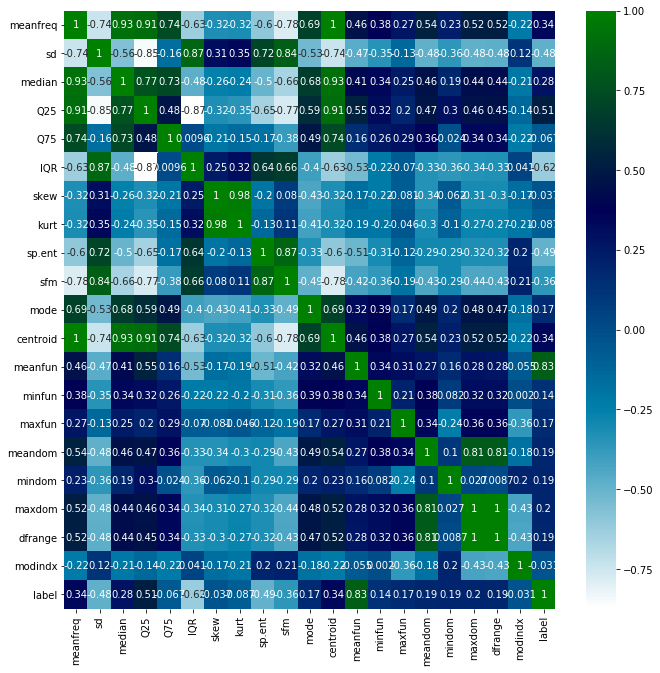

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df=df.dropna()

plt.figure(figsize=(11, 11))
sns.heatmap(df.corr(),annot=True,cmap='ocean_r',cbar=True)
plt.show()

A partir dessa matriz, é possível analizar como todas as features se correlacionam, sendo a maioria das vezes interessante que haja uma baixa correlação entre duas features, pois significa dizer que o peso adicionado pelas features estariam sendo utilizados com eficiência.

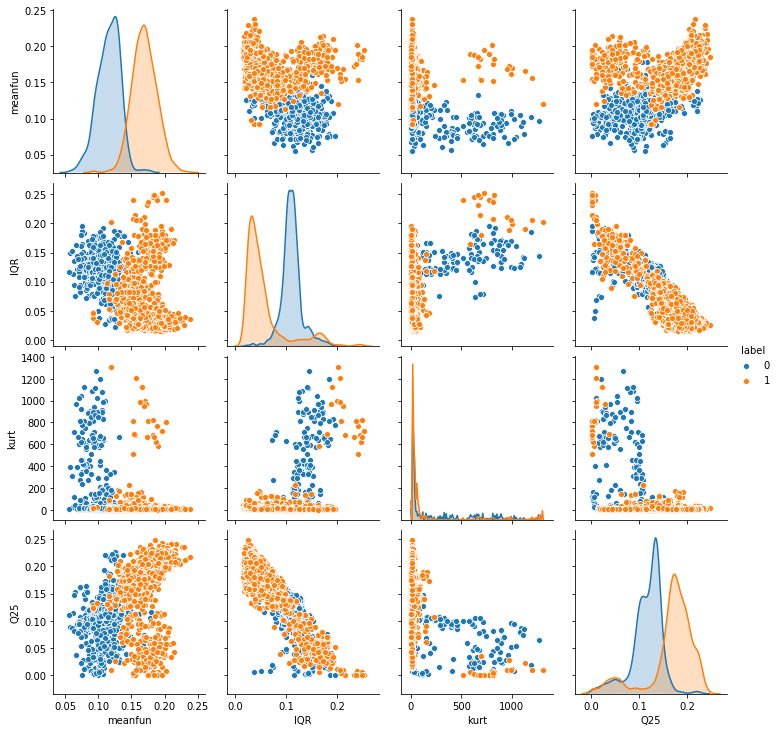

In [27]:
sns.pairplot(df,hue = 'label', vars=['meanfun', 'IQR', 'kurt', 'Q25'])

A visualização do pairplot também se mostra uma ótima ferramenta para verificar quais parâmetros são importantes para utilização no modelo. 

Por se tratar de um problema binário, a acurácia se mostra uma boa métrica para medir a eficiência de classificação do modelo, bem como a precisão.  

# Dataset Não Supervisionado

O dataset esclhido para o não supervisionado corresponde a um conjunto de informações quantitativas e qualitativas de diferentes produtos de comida. 

In [0]:
link = 'https://drive.google.com/open?id=1DeO00C66Se6bp1PptqfsyE7a2nJF-IpN'

fluff, id = link.split('=')

# Dataset Import
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Filename.csv')
df = pd.read_csv('Filename.csv', sep='\t', low_memory=False)

A seguir, é apresentado todas as colunas com seus valores de índices aleatóriosa do dataframe em questão. Nele, verificamos que existem muitas colunas, sendo a maioria numéricas e que representam as quantidades de certos nutrientes nas comidas.

In [29]:
df.sample(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
297322,501291151,http://world-en.openfoodfacts.org/product/5012...,date-limite-app,1438257158,2015-07-30T11:52:38Z,1461433126,2016-04-23T17:38:46Z,Jambon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:CH,en:switzerland,Switzerland,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323458,7613269211143,http://world-en.openfoodfacts.org/product/7613...,openfood-ch-import,1486510042,2017-02-07T23:27:22Z,1487257414,2017-02-16T15:03:34Z,Pâte à tarte flambée,NaN,NaN,NaN,NaN,Anna's Best,anna-s-best,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suisse,en:switzerland,Switzerland,"farine de blé, eau, graisses et huiles végétal...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN,NaN
83338,0072989765416,http://world-en.openfoodfacts.org/product/0072...,usda-ndb-import,1489074540,2017-03-09T15:49:00Z,1489074540,2017-03-09T15:49:00Z,Celestial Sours,NaN,NaN,NaN,NaN,"Marczyk Fine Foods, Jerry's Nut House Inc.","marczyk-fine-foods,jerry-s-nut-house-inc",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,United States,"Sugar, corn syrup, cornstarch, fumaric acid, c...",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,15.0,NaN,NaN
254216,3538280837254,http://world-en.openfoodfacts.org/product/3538...,openfoodfacts-contributors,1369661564,2013-05-27T13:32:44Z,1486821472,2017-02-11T13:57:52Z,La Vosgienne Parfums Framboise Citron Orange,Confiseries aromatisées,125g,"Boîte,Metal","boite,metal",Cadbury,cadbury,Bonbons,"en:sugary-snacks,en:confectioneries,en:candies","Sugary snacks,Confectioneries,Candies",NaN,NaN,Espagne,espagne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
182461,20425524,http://world-en.openfoodfacts.org/product/2042...,openfoodfacts-contributors,1491751096,2017-04-09T15:18:16Z,1491751141,2017-04-09T15:19:01Z,Légumes vapeur,NaN,640gr,NaN,NaN,Freshona,freshona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,...,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,283867.000000,283867.000000,0.0,283867.000000,0.0,0.0,295367.000000,869.000000,2.794970e+05,263823.000000,0.0,0.0,1.0,2.000000,4.000000,1.0,1.0,1.0,27.000000,26.000000,0.0,0.0,1.0,0.0,23040.000000,23075.000000,938.000000,201.000000,43.000000,89.000000,207.000000,159.000000,9.000000,27.000000,26.000000,25.000000,15.000000,0.0,1.600000e+01,...,930.000000,141060.000000,11277.000000,10925.000000,11831.000000,6897.000000,5330.000000,3046.000000,5.390000e+03,331.000000,2551.000000,73.000000,99.000000,24848.000000,198.000000,141517.000000,5938.000000,140660.000000,6392.000000,3964.000000,2122.000000,1639.000000,99.000000,1181.000000,23.000000,20.000000,288.000000,91.000000,33.000000,52.000000,3228.000000,404.000000,182.000000,1383.000000,0.0,278.000000,254856.000000,254856.000000,0.0,0.0
mean,NaN,1.876851,0.023430,NaN,0.059736,NaN,NaN,1125.453320,587.216617,5.606587e+04,5.092460,NaN,NaN,7.4,6.040000,36.136182,18.9,8.1,3.0,10.383852,10.265385,NaN,NaN,61.0,NaN,10.501218,6.372548,3.476176,2.200218,2.805791,1.581979,18.734295,12.463013,0.051344,0.158230,0.063246,41.243200,26.053333,NaN,1.343750e-06,...,0.033854,0.023394,0.332167,0.256490,0.020410,0.046952,0.006820,0.205586,2.741797e-04,0.000134,0.069210,0.433009,0.132496,0.424284,0.079895,0.127284,0.613267,0.003791,0.531415,0.007921,0.025613,0.003165,0.010042,0.003098,0.001478,0.000230,0.000465,2.075503,12.262055,6.476138,33.392680,60.360124,15.362637,52.102675,NaN,335.790664,9.166137,8.980656,NaN,NaN
std,NaN,2.501022,0.153094,NaN,0.280660,NaN,NaN,936.825952,713.255708,2.963385e+07,7.965148,NaN,NaN,NaN,0.226274,24.101433,NaN,NaN,NaN,3.939718,3.388090,NaN,NaN,NaN,NaN,16.789189,10.930572,8.665162,7.778110,13.114442,1.981251,32.590392,110.915670,0.029298,0.030498,0.011144,25.061032,25.545541,NaN,4.643544e-07,...,1.024723,2.234928,2.619725,1.270840,0.338304,1.665441,0.332325,5.128884,1.907492e-02,0.000787,1.455822,1.381336,0.214015,12.503642,0.132836,3.349236,11.963513,0.216565,13.360342,0.080598,0.910794,0.028289,0.060819,0.103926,0.006248,0.000834,0.001604,7.725321,69.605988,2.013490,32.906834,29.262350,3.692658,19.028361,NaN,423.244817,8.999870,9.151757,NaN,NaN
min,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000e+00,0.000000,NaN,NaN,7.4,5.880000,0.044730,18.9,8.1,3.0,0.064000,5.200000,NaN,NaN,61.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.006100,0.050000,0.090000,0.006100,0.095000,0.043307,1.000000,1.080000,NaN,1.000000e-06,...,0.000000,-0.002100,0.000000,

Apesar de existirem muitos campos nulos, a variedade de colunas com quantidades de nutrientes permite o agrupamento sem supervisionamento de diversas combinações diferentes. Isso permite a formação de *clusters* de comidas que possuem proporções nutricionais parecidas, podendo identificar os tipos de comidas ou até separar comidas por dietas específicas.